In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../fuzzy-tools') # or just install the module

In [2]:
from fuzzytools.files import search_for_filedirs
from lchandler import _C

root_folder = '../../surveys-save'
filedirs = search_for_filedirs(root_folder, fext=_C.EXT_RAW_LIGHTCURVE)

────────────────────────────────────────────────────────────────────────────────────────────────────
found filedirs: (../../surveys-save)
(0) - ../../surveys-save/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds - 1.723[mbs]
(1) - ../../surveys-save/b/wiib/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds - 1.723[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────
filedirs after searching with filters: (../../surveys-save)
(0) - ../../surveys-save/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds - 1.723[mbs]
(1) - ../../surveys-save/b/wiib/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds - 1.723[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────


In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from fuzzytools.progress_bars import ProgressBar
from fuzzytools.files import load_pickle, save_pickle
from fuzzytools.files import get_dict_from_filedir

filedir = f'../../surveys-save/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds'
filedict = get_dict_from_filedir(filedir)
root_folder = filedict['_rootdir']
cfilename = filedict['_cfilename']
survey = filedict['survey']
lcdataset = load_pickle(filedir)
print(lcdataset)

LCDataset:
[outliers; samples 4]
(.) obs_samples=289; min_len=14; max_dur=408.0[days]; dur(p50)=222.1[days]; cadence(p50)=0.9[days]
(g) obs_samples=144; min_len=6; tmax=44.923828125; max_dur=408.0 [days]; dur(p50)=222.0 [days]; cadence(p50)=1.9 [days]
(r) obs_samples=145; min_len=8; tmax=212.09375; max_dur=376.0 [days]; dur(p50)=220.4 [days]; cadence(p50)=2.0 [days]
   |██      | SLSN - 1/4 (25.00%)
   |████    | SNII* - 2/4 (50.00%)
   |██      | SNIa - 1/4 (25.00%)
   |        | SNIbc - 0/4 (0.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint; samples 0]
empty lcset
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw; samples 1,994]
(.) obs_samples=54,685; min_len=6; max_dur=538.8[days]; dur(p50)=52.9[days]; cadence(p50)=1.0[days]
(g) obs_samples=24,132; min_len=0; tmax=10.99609375; max_dur=538.8 [days]; dur(p50)=39.0 [days]; cadence(p50)=3.0 [days]
(r) obs_samples=30,

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[]

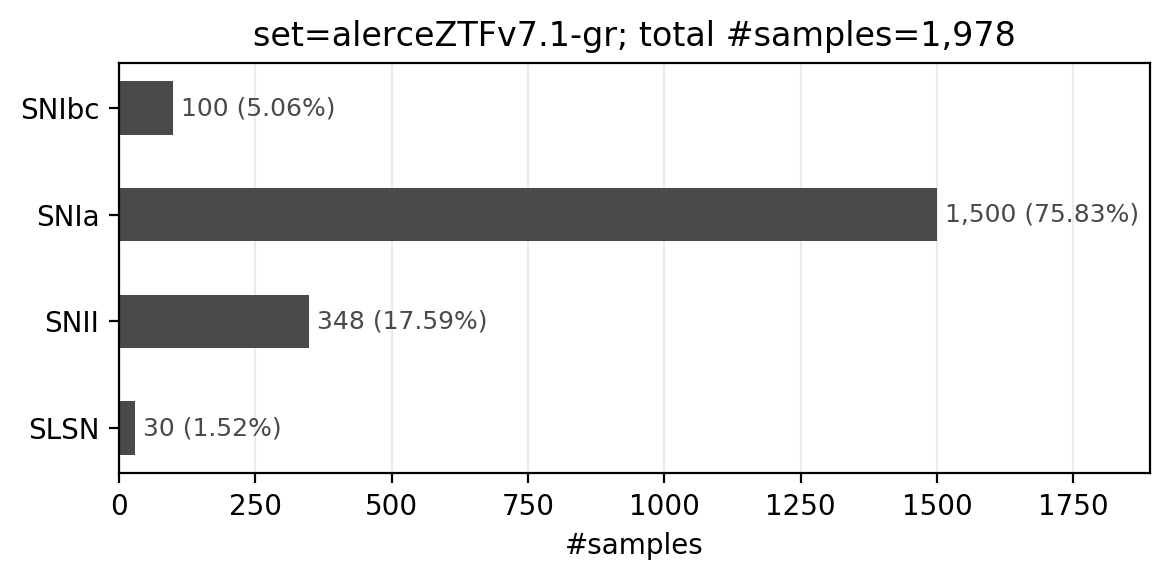

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import fuzzytools.matplotlib.plots as cplots
import fuzzytools.matplotlib.colors as cc
from fuzzytools.matplotlib.utils import save_fig

SNIIb_obj_names = ['ZTF18abojpnr', 'ZTF19aaugupw', 'ZTF19aawethv', 'ZTF18acbzoyh', 'ZTF18acqxyiq', 'ZTF18acrcyqw', 'ZTF19aadpqnb', 'ZTF19aaknate', 'ZTF19aalzvnu', 'ZTF19abqykei', 'ZTF19abqmsnk', 'ZTF19acyjjni', 'ZTF19aczmnqy', 'ZTF19aaejtof', 'ZTF20aawefgx', 'ZTF20aaxhzhc']
populations_cdict = lcdataset.split('raw',
    shuffle=True,
    random_state=0,
    outlier_obj_names=SNIIb_obj_names,
    )
#print(populations_cdict)

lcset = lcdataset['raw']
lcobj_classes = []
for c in lcset.class_names:
    lcobj_classes += [c.replace('*', '')]*len(populations_cdict[c])

title = ''
title += f'set={lcset.survey}-{"".join(lcset.band_names)}; total #samples={len(lcobj_classes):,}'+'\n'
plt_kwargs = {
    #'ylabel':'' if ks>0 else None,
    'title':title[:-1],
    #'uses_log_scale':True,
    'figsize':[6,3],
    'cmap':cc.colorlist2cmap([cc.NICE_GRAY]),
    'xlabel':'#samples',
    }
fig, ax = cplots.plot_hist_labels({'raw':lcobj_classes}, [c.replace('*', '') for c in lcset.class_names], **plt_kwargs)
fig.tight_layout()
save_fig(fig, f'../temp/classes.pdf', closes_fig=0)
plt.plot()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


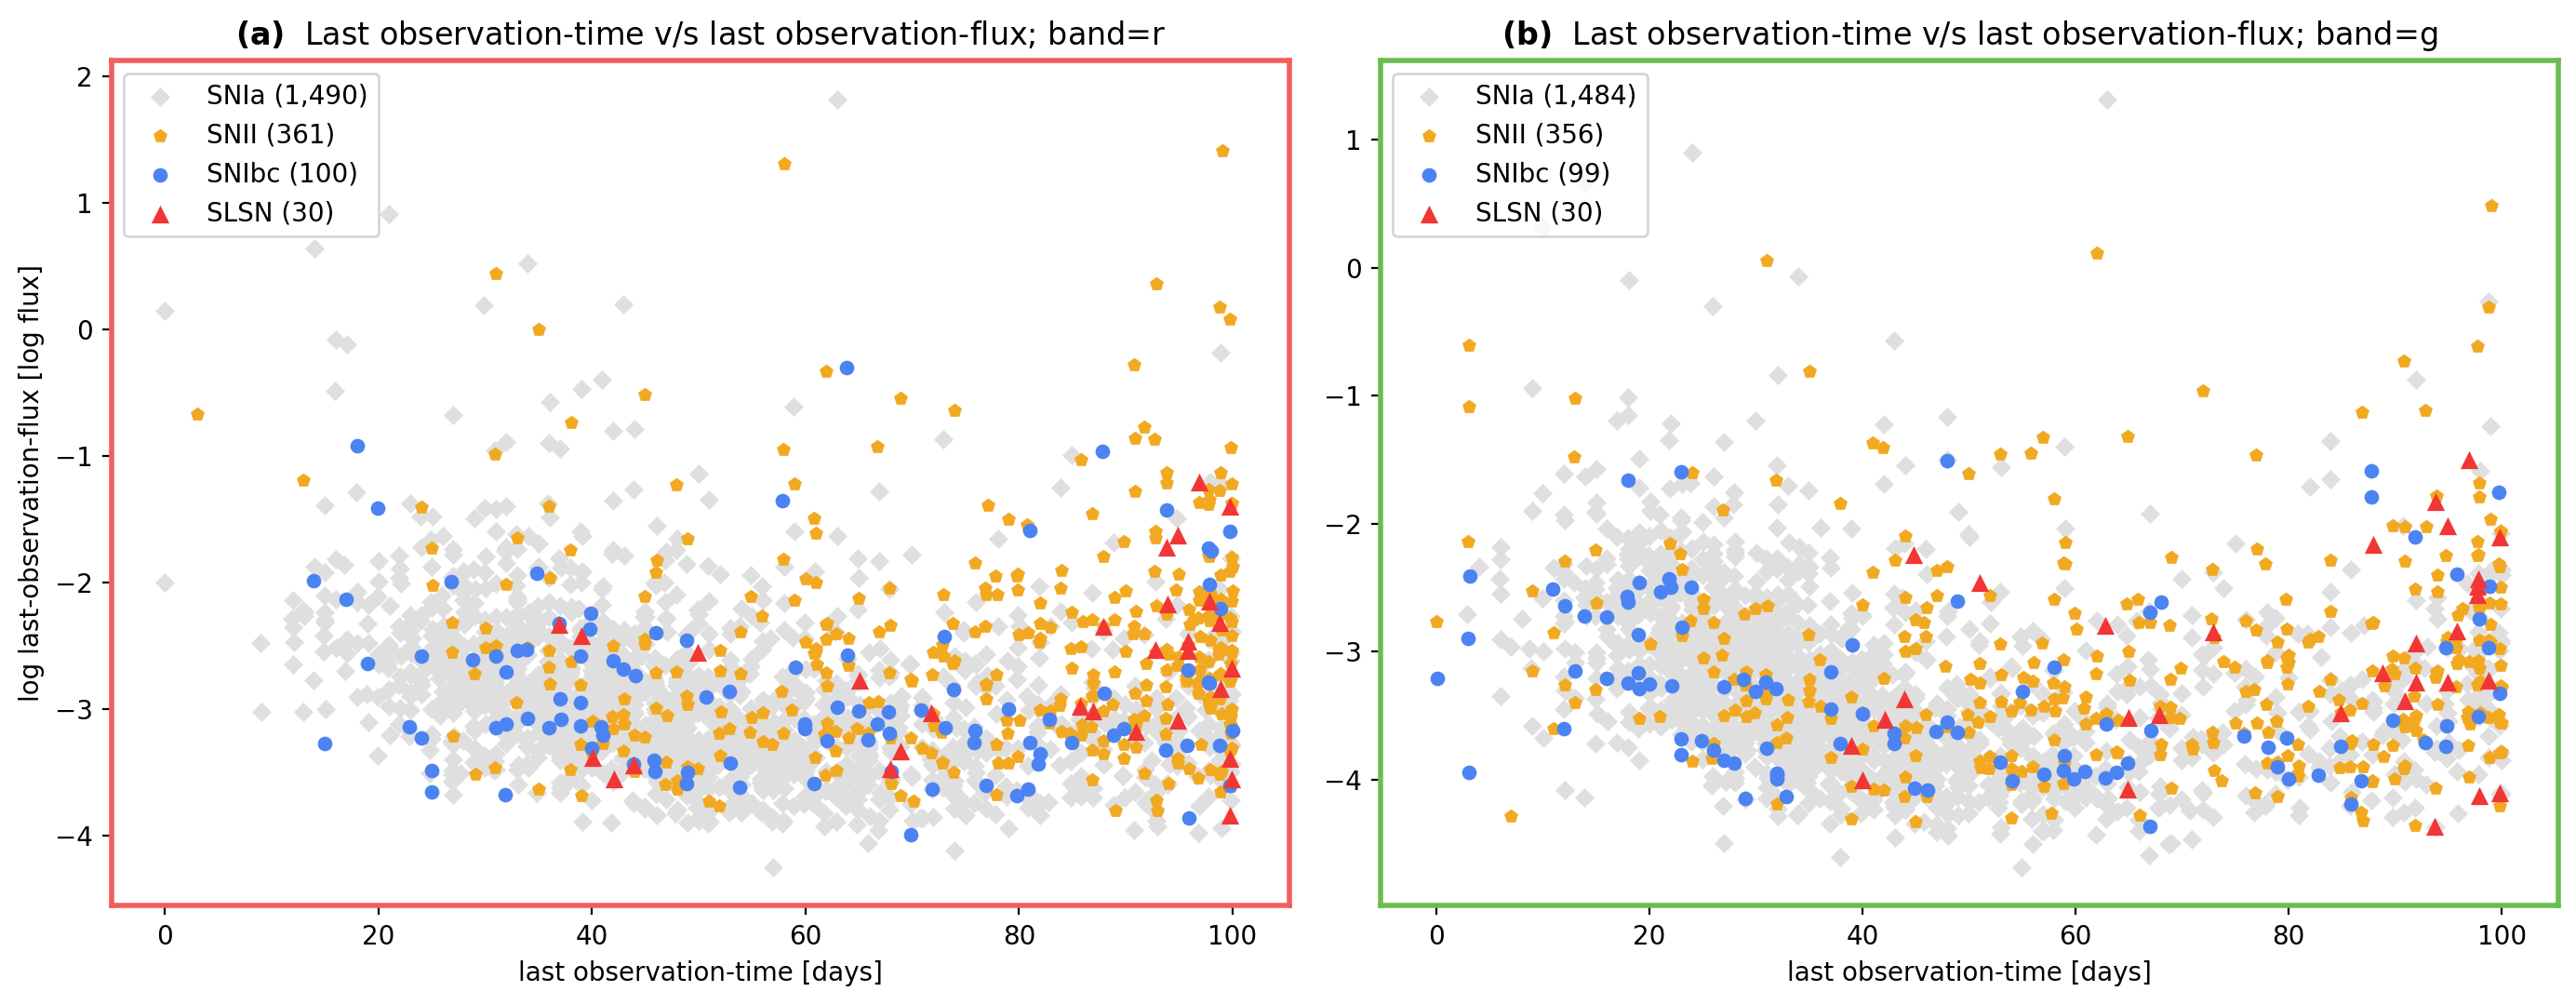

In [5]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from fuzzytools.matplotlib.scatters import scatter
from fuzzytools.matplotlib.colors import get_scaled_color
import fuzzytools.matplotlib.ax_styles as ax_styles
import numpy as np
from lchandler._C import CLASSES_STYLES, COLOR_DICT
from fuzzytools.strings import latex_bf_alphabet_count
from fuzzytools.matplotlib.utils import save_fig

set_name = f'raw'
lcobj_names = lcdataset[set_name].get_lcobj_names()
thday = 100
figsize = (14, 5.5)
dpi = 200
fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
band_names = ['r', 'g']
class_names = lcdataset[set_name].class_names
for kb,b in enumerate(band_names):
    ax = axs[kb]
    x = []
    y = []
    for lcobj_name in lcobj_names:
        lcobj = lcdataset[set_name][lcobj_name]
        lcobjb = lcobj.get_b(b)
        lcobjb.clip_attrs_given_max_day(thday) # clip by max day
        if len(lcobjb)>0:
            x += [[lcobjb.days[-1], np.log(lcobjb.obs[-1])]]
            y += [lcobj.y]
            
    scatter_kwargs = {}
    for kc,c in enumerate(class_names):
        scatter_kwargs[c] = {
            's':32*CLASSES_STYLES[c]['markerprop'],
            'color':get_scaled_color(CLASSES_STYLES[c]['c'], 2.5) if c=='SNIa' else CLASSES_STYLES[c]['c'],
            'marker':CLASSES_STYLES[c]['marker'],
            'edgecolor':'w',
            'linewidths':0,
            'alpha':1,
            'label':c.replace('*', ''),
            }
    x = np.array(x)
    y = np.array(y)
    scatter(ax, x, y, class_names, scatter_kwargs, label_format='{label} ({count}#)')
    ax_styles.set_color_borders(ax, COLOR_DICT[b])
    title = ''
    title = f'{latex_bf_alphabet_count(kb)} Last observation-time v/s last observation-flux; band={b}'+'\n'
    ax.set_title(title[:-1])
    ax.legend(loc='upper left')
    ax.set_xlabel('last observation-time [days]')
    if kb==0:
        ax.set_ylabel('log last-observation-flux [log flux]')
    
fig.tight_layout()
save_fig(fig, f'../temp/img.pdf', closes_fig=0)
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


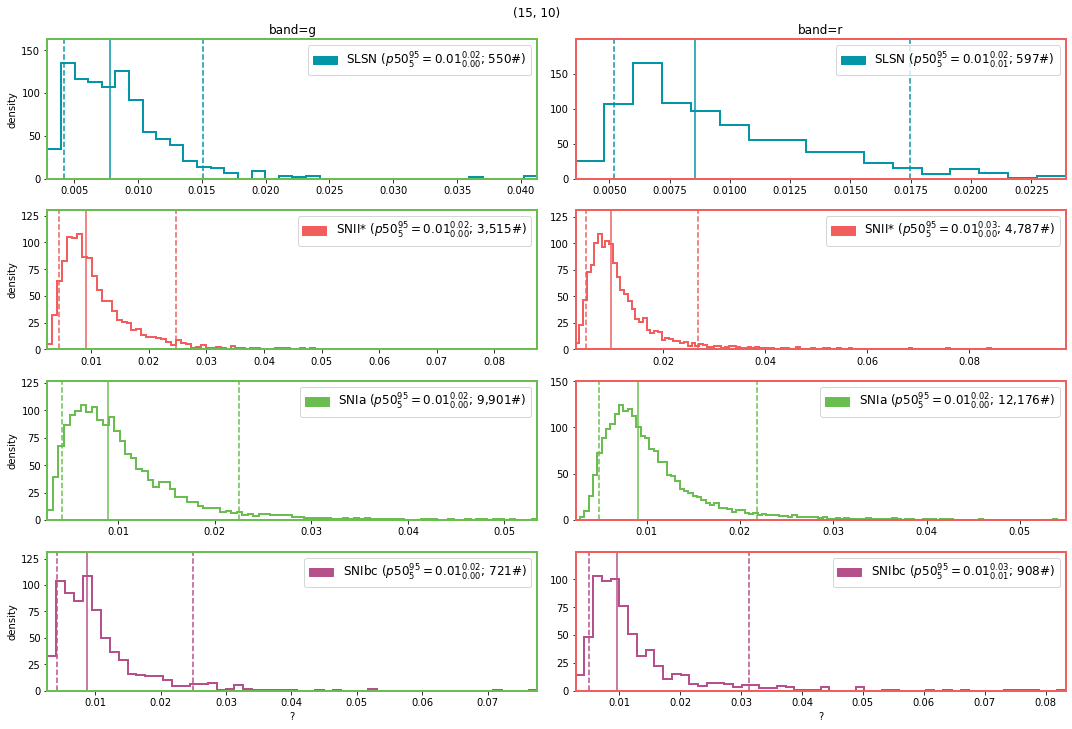

In [6]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_sigma_distribution

plot_sigma_distribution(lcdataset, f'0@raw_train')

In [7]:
%load_ext autoreload
%autoreload 2

for kf in lcdataset.kfolds:
    for ks,set_name in enumerate([f'{kf}@raw_train', f'{kf}@raw_val', f'{kf}@raw_test']):
        lcdataset.sigma_clipping(set_name, set_name.replace('raw_',''),
            sigma_n=1,
            sigma_m=5, # 1, 3, 5
            apply_lower_bound=False,
            verbose=1,
            )

print(lcdataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tru

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True

In [8]:
assert 0

AssertionError: 

In [ ]:
lcdataset['1@test'].get_lcobj_names()

In [ ]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_sigma_distribution

plot_sigma_distribution(lcdataset, '0@train')

In [ ]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_class_distribution

plot_class_distribution(lcdataset, ['0@train', '0@val', '0@test'])

In [ ]:
from fuzzytools.files import load_pickle, save_pickle
from lchandler import _C

new_cfilename = f'{cfilename}'
save_filedir = f'{root_folder}/{new_cfilename}.{_C.EXT_SPLIT_LIGHTCURVE}'
save_pickle(save_filedir, lcdataset)